### Import List

In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

### Data Input

In [232]:
df = pd.read_json('../data/train.json')
df

,id,cuisine,ingredients
0,42302,southern_us,"[egg whites, pecans, agave nectar, ground cinn..."
1,43202,greek,"[large egg whites, whole milk, bread crumb fre..."
2,31619,cajun_creole,"[sugar, vegetable oil, yeast, eggs, evaporated..."
3,30920,korean,"[honey, rice vinegar, brown sugar, ginger, gar..."
4,46567,italian,"[mushroom caps, asiago, large shrimp, fat free..."
...,...,...,...
29769,24516,greek,"[mayonaise, mahimahi fillet, tomatoes, extra-v..."
29770,49253,mexican,"[neutral oil, ground black pepper, tomatillos,..."
29771,4861,french,"[tomatoes, chopped fresh thyme, fresh mushroom..."
29772,529,mexican,"[unsalted butter, chees fresco queso, lime, ch..."


### Data Visualization

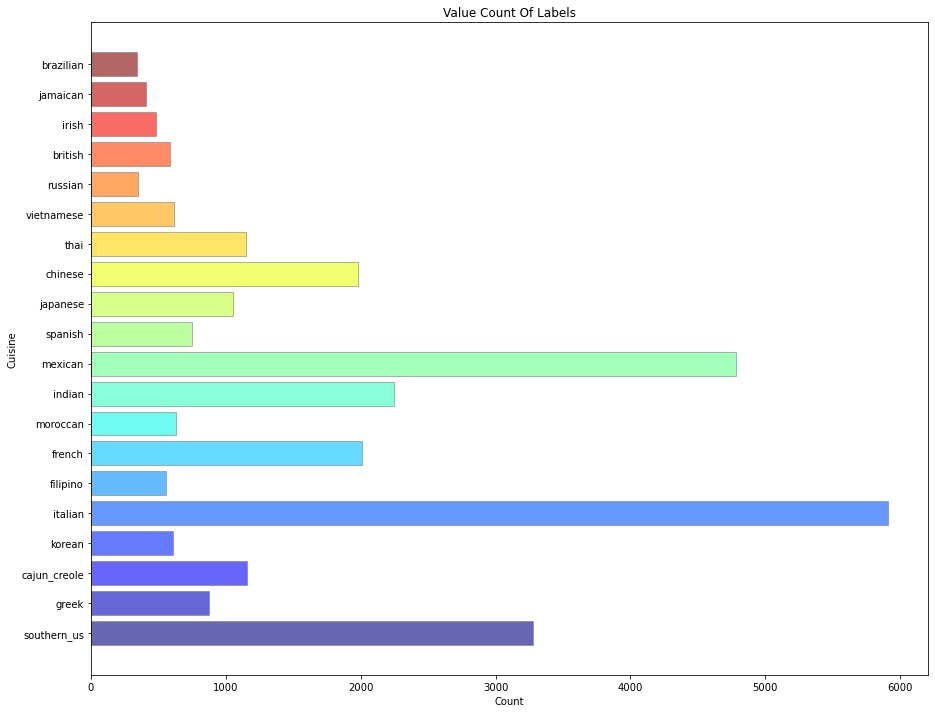

In [233]:
# Plot the data distribution by value count of their labels (targets)
def beautiful_plot(X, Y, x_label, y_label, title):
    x = np.arange(len(X))
    y = Y
    
    plt.figure(figsize=(15,12))
    cmap = cm.jet(np.linspace(0, 1, len(X)))
    plt.barh(x, y, edgecolor = 'gray', alpha=0.6, color=cmap)
    plt.yticks(x, X)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


label_count = {}

for _, row in df.iterrows():
    if row['cuisine'] in label_count:
        label_count[row['cuisine']] += 1
    else:
        label_count[row['cuisine']] = 1

beautiful_plot(label_count.keys(), label_count.values(), 'Count', 'Cuisine', 'Value Count Of Labels')

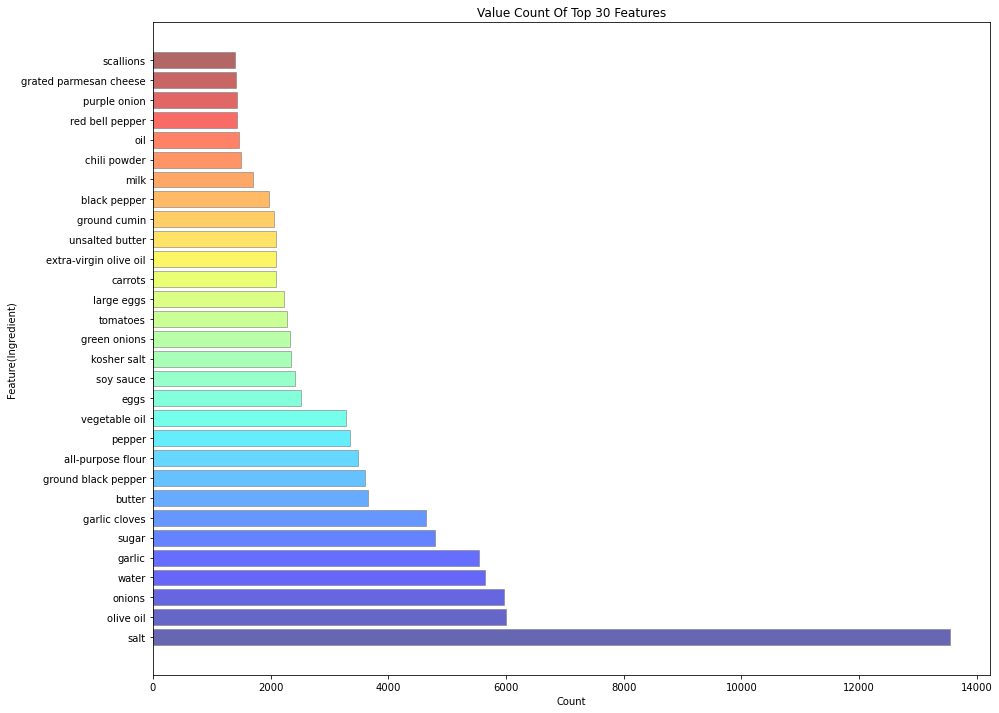

In [234]:
# Plot the data distribution by value count of top 30 features.
feature_count = {}

for _, row in df.iterrows():
    for ele in row['ingredients']:
        if ele in feature_count:
            feature_count[ele] += 1
        else:
            feature_count[ele] = 1

s = sorted(feature_count.items(), key=lambda item: item[1], reverse=True)[:30]

x_list = [k for k, _ in s]
y_list = [v for _, v in s]
beautiful_plot(x_list, y_list, 'Count', 'Feature(Ingredient)', 'Value Count Of Top 30 Features')

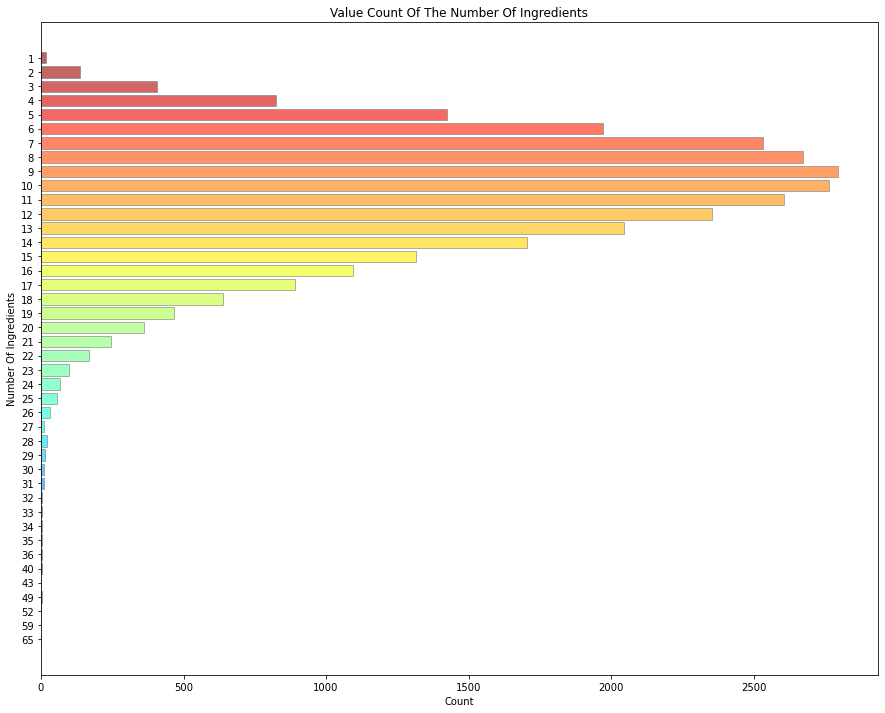

In [235]:
# Plot the data distribution by value count of the number of ingredients.
ing_num_count = {}

for _, row in df.iterrows():
    k = len(row['ingredients'])
    if k in ing_num_count:
        ing_num_count[k] += 1
    else:
        ing_num_count[k] = 1

s = sorted(ing_num_count.items(), key=lambda item: item[0], reverse=True)
x_list = [k for k, _ in s]
y_list = [v for _, v in s]     
beautiful_plot(x_list, y_list, 'Count', 'Number Of Ingredients', 'Value Count Of The Number Of Ingredients')

### Data Preprocessing

In [236]:
# Shuffle the data
df = shuffle(df)

# Transform data format and shape
data = df.copy()
target = data['cuisine']
raw_sample = data.drop('cuisine', 1).drop('id', 1)

# one-hot encoding
sample = pd.DataFrame()
index = 0
num_of_row = len(raw_sample['ingredients'])

for ing in raw_sample['ingredients']:
    for ele in ing:
        num_of_column = len(sample.columns)
        
        if ele in sample:
            sample.loc[index, ele] = 1
        else:
            sample.insert(num_of_column, ele, [0 for i in range(num_of_row)])
            sample.loc[index, ele] = 1
    
    index += 1
    
sample

,water,food colouring,coconut milk,potato starch,glutinous rice flour,sugar,basil pesto sauce,tuna,tomatoes,prepared mustard,...,italian style rolls,Jarlsberg,plum wine,bottled chili sauce,chunky style pasta sauce,Lipton Lemon Iced Tea Mix,Knudsen Sour Cream,agar agar flakes,pot stickers,wild asparagus
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29770,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29772,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
num_of_column = len(sample.columns)

# create target:int map
target_map = {}
i = 0
for t in target:
    if t not in target_map:
        target_map[t] = i
        target_map[i] = t
        i += 1
target = np.array([target_map[t] for t in target])

# traing-test-split 7:3
training_sample, testing_sample, training_target, testing_target = train_test_split(sample, target, test_size = 0.3) 

# transfer to numpy array
x_training_sample = training_sample.to_numpy()
x_testing_sample = testing_sample.to_numpy()

# to pytorch numpy
T_training_sample = torch.FloatTensor(x_training_sample)
T_training_target = torch.LongTensor(training_target).type(torch.LongTensor)

T_testing_sample = torch.FloatTensor(x_testing_sample)
T_testing_target = torch.LongTensor(testing_target).type(torch.LongTensor)

In [238]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(T_training_sample, T_training_target)
test = torch.utils.data.TensorDataset(T_testing_sample, T_testing_target)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

### Model Construction

In [239]:
class ANNModel(nn.Module):
    def __init__(self, input_features, hidden_layer1, output_features):
        super().__init__()
        self.fc1 = nn.Linear(input_features, hidden_layer1) 
        self.Sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)


    def forward(self, x):
        out = self.fc1(x)
        out = self.Sigmoid1(out)
        out = self.fc2(out)

        return out
    

input_feature = num_of_column
hidden_layer1 = 500
output_features = 20 # number of type of target

# Create ANN
model = ANNModel(input_feature, hidden_layer1, output_features)

# Cross Entropy Loss 
criterion = nn.CrossEntropyLoss()

# SGD Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Model Training

In [240]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
print(num_epochs)
epochs = 60

for i in range(epochs):
    pred = model.forward(T_training_sample)
    
    optimizer.zero_grad() # Clear gradients
    loss = criterion(pred, T_training_target)
    loss_list.append(loss)
    loss.backward() # Calculating gradients
    optimizer.step() # Update parameters
    

    print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    preds = []
    with torch.no_grad():
        for val in T_testing_sample:
            y_hat = model.forward(val)
            preds.append(y_hat.argmax().item())
    acc = accuracy_score(testing_target, preds)
    print("Accuracy: {}".format(acc))

0
epoch:  0  loss: 5.57752466
Accuracy: 0.08798835777454382
epoch:  1  loss: 2.96558380
Accuracy: 0.16825254673681853
epoch:  2  loss: 2.56415200
Accuracy: 0.23429978730549647
epoch:  3  loss: 2.71097207
Accuracy: 0.2594872943020262
epoch:  4  loss: 2.62114120
Accuracy: 0.4468823463562073
epoch:  5  loss: 2.48587227
Accuracy: 0.5214373670659352
epoch:  6  loss: 2.37999010
Accuracy: 0.5029665286018135
epoch:  7  loss: 2.20523739
Accuracy: 0.5031904175528937
epoch:  8  loss: 2.03570175
Accuracy: 0.5005037501399306
epoch:  9  loss: 1.92649710
Accuracy: 0.5054293070636964
epoch: 10  loss: 1.84249127
Accuracy: 0.5477443188178663
epoch: 11  loss: 1.72729814
Accuracy: 0.6047240568677936
epoch: 12  loss: 1.61536062
Accuracy: 0.6349490652636293
epoch: 13  loss: 1.51536095
Accuracy: 0.6359565655434904
epoch: 14  loss: 1.43511808
Accuracy: 0.6346132318370088
epoch: 15  loss: 1.36078513
Accuracy: 0.6352848986902496
epoch: 16  loss: 1.28660738
Accuracy: 0.6441285122579201
epoch: 17  loss: 1.2178896

### Deal With Test Data

In [244]:
df = pd.read_json('../data/test.json')

# Transform data format and shape
data = df.copy()
raw_submit_sample = data.drop('id', 1)

# one-hot encoding
submit_sample = pd.DataFrame(0, index=raw_submit_sample.index, columns = sample.columns[:])
submit_sample
index = 0

for ing in raw_submit_sample['ingredients']:
    for ele in ing:
        if ele in submit_sample:
            submit_sample.loc[index, ele] = 1
    index += 1

submit_sample

,water,food colouring,coconut milk,potato starch,glutinous rice flour,sugar,basil pesto sauce,tuna,tomatoes,prepared mustard,...,italian style rolls,Jarlsberg,plum wine,bottled chili sauce,chunky style pasta sauce,Lipton Lemon Iced Tea Mix,Knudsen Sour Cream,agar agar flakes,pot stickers,wild asparagus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [246]:
x_testing_sample = submit_sample.to_numpy()
T_testing_sample = torch.FloatTensor(x_testing_sample)

preds = []
with torch.no_grad():
    for val in T_testing_sample:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())

submission = []
for p in preds:
    submission.append(target_map[p])
    
submission_df = pd.DataFrame(submission, columns=['Category'])
print(data['id'])
submission_df.insert(0, 'id', data['id'])
submission_df
submission_csv = submission_df.to_csv(r'/Users/yantinchen/Developer/machine-learning-basic/ANN-learning/sm.csv', index=False)

0          14
1          22
2          24
3          37
4          40
        ...  
9995    49692
9996    49693
9997    49697
9998    49709
9999    49710
Name: id, Length: 10000, dtype: int64
